# Projet de modélisation d'un mix énergétique issu 100% d'ENR

## XI. Typical days clustering

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
colors = ["palevioletred", "mediumaquamarine", "cornflowerblue", "royalblue", "slategray", 
          "mediumseagreen", "salmon", "yellow", "khaki", "0.2"]

In [3]:
ans = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

In [4]:
from typical_days import Profils_vre_datetime 
profils_off, profils_on, profils_pv = Profils_vre_datetime()

## Typical days clustering

Creation des clusters avec un représentant du groupe de jours aux mêmes caractéristiques (variance et moyenne)

#### Profils de production, de moyenne et de variance sur 18 ans

In [5]:
def mean_std_profil_18(profil, verbose_mean=True):
    #Création d'un DataFrame avec les 18 années de production 
    df = np.zeros(18*8760)

    for i in range(18):
        s = profil[ans[i]]
        df[8760*i:8760*(i+1)] = s

    df = pd.DataFrame(df)
    time = '2000-01-31'
    df.index = pd.to_datetime(df.index, unit='h', origin=pd.Timestamp(time))

    if verbose_mean:
        df_mean = df.resample('D').mean()  #moyennes de production journalières sur 18 ans
    else:
        df_mean = df.resample('D').std()  #ecart-types de production journalières sur 18 ans

    return df_mean, df 

In [6]:
off_day_mean_18, off_18 = mean_std_profil_18(profils_off)
off_day_std_18, _ = mean_std_profil_18(profils_off, False)
on_day_mean_18, on_18 = mean_std_profil_18(profils_on)
on_day_std_18, _ = mean_std_profil_18(profils_on, False)
pv_day_mean_18, pv_18 = mean_std_profil_18(profils_pv)
pv_day_std_18, _ = mean_std_profil_18(profils_pv, False)
pv_on_18 = (pv_18 + on_18)

#### Tableau des coordonnées pour chaque jour de moyenne et de variance

In [7]:
def Array_mean_std(day_mean_18, day_std_18):
    df = np.zeros((18*365,2))
    for i in range(18*365):
        df[i,0] = day_mean_18[0].iloc[i]
        df[i,1] = day_std_18[0].iloc[i]
    return df

array_on = Array_mean_std(on_day_mean_18, on_day_std_18)
array_off = Array_mean_std(off_day_mean_18, off_day_std_18)
array_pv = Array_mean_std(pv_day_mean_18, pv_day_std_18)

## Kmedoids clustering

In [8]:
from sklearn_extra.cluster import KMedoids

def Clustering_days(df, n_clusters, verbose_plot=False, verbose_return=True):
    # — — — — — — -Assigning Initial Centers — — — — — — — — — — — -
    #centers = [df[0], df[-1]]

    # — — — — — — -Fit KMedoids clustering — — — — — — — — — — — -
    KMobj = KMedoids(n_clusters=n_clusters).fit(df)

    # — — — — — — -Assigning Cluster Labels — — — — — — — — — — — -
    labels = KMobj.labels_
    
    # — — — — — — -Extracting Unique Labels — — — — — — — — — — — -
    unq_lab = set(labels)

    # — — — — — — -Setting Up Color Codes — — — — — — — — — — — -
    colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unq_lab))]

    for k, col in zip(unq_lab, colors_plot):
        class_member_mask = labels == k

         # — — — — — — -Setting datapoint Feature X and Feature Y — — — — — — — — — — — -
        xy = df[class_member_mask]
        
        if verbose_plot:
             # — — — — — — -Plotting Feature X and Feature Y for each cluster labels — — — — — — — — — — — -
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'white', markersize=10)
    
    if verbose_plot:
        # — — — — — — -Annotate Centroids — — — — — — — — — — — -
        plt.plot(KMobj.cluster_centers_[:, 0], KMobj.cluster_centers_[:, 1], 'o', markerfacecolor='orange', markeredgecolor='k',
                 markersize=10)

        # — — — — — — -Add title to the plot — — — — — — — — — — — -
        plt.title("KMedoids clustering (centers in orange)", fontsize = 14)
        plt.show()
    
    if verbose_return:
        return KMobj.cluster_centers_, labels

#### Typical days

In [9]:
def Index_centers(n_clusters, centers, labels, array):    
    index_centers = np.zeros((n_clusters), dtype=int)
    for i in range(n_clusters):
        for j in range(len(np.where(array == centers[i]))):
            if np.where(array == centers[i])[j][0] == np.where(array == centers[i])[j][1]:
                index_centers[i] = np.where(array == centers[i])[j][0]
    return index_centers

In [10]:
def Typical_days(n_clusters, centers, labels, array, p_18): 
    typical_days = np.zeros((24,len(centers)))
    index_centers = Index_centers(n_clusters, centers, labels, array)
    for ind in range(len(index_centers)):
        typical_days[:,ind] = p_18[index_centers[ind]*24:(index_centers[ind]+1)*24][0]
    return typical_days

#### Typical years

In [11]:
def Typical_year(n_clusters, centers, labels, array, p_18, an): 
    typical_days = Typical_days(n_clusters, centers, labels, array, p_18)
    typical_year = np.zeros(8760)

    for i in range(365):
        typical_year[i*24:(i+1)*24] = typical_days[:,labels[i+an*365]]
    return typical_year

## Prise en compte du recollement des jours pour l'éolien

In [12]:
def H23_H24(profils):
    h23 = []
    h24 = []
    for i in range(18):
        for j in range(365):
            h23 += [profils[ans[i]].iloc[24*j-1]]
            h24 += [profils[ans[i]].iloc[24*j]]
    h23 = np.array(h23)
    h24 = np.array(h24)
    return h23, h24

h23_off, h24_off = H23_H24(profils_off)
h23_on, h24_on = H23_H24(profils_on)

In [13]:
y,x = np.histogram(h24_off-h23_off, bins=1000)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))
fig.update_layout(title="Différence entre 23h et minuit", yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [14]:
y1, x1 = np.histogram(h23_off, bins=1000)
y2, x2 = np.histogram(h24_off, bins=1000)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x1, y=y1, name='23h'))
fig.add_trace(go.Scatter(x=x2, y=y2, name='Minuit'))
fig.update_layout(title="Histogramme des valeurs de production entre 23h et minuit", yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [15]:
def Clusters_23h(df, centers, labels, labels_h23, groups_h23, n_clusters, nb_groups, verbose_return=False):
    new_centers = []
    new_labels = np.zeros_like(labels)
    colors_plot = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_clusters)]

    for j in range(nb_groups-1):
        for k, col in zip(range(n_clusters), colors_plot):
            class_member_mask_1 = labels == k
            class_member_mask_2 = labels_h23 == j
            class_member_mask = class_member_mask_1 * class_member_mask_2  #dans le cluster k on veut les jours dont la production à 23h est dans le gpe j

            if np.shape(np.where(class_member_mask == True))[1]==0:
                print('Groupe ', k, " avec h23 dans le groupe ", j, ' Aucun')

            xy = df[class_member_mask]
            
            if verbose_return:
                a = np.random.randint(0,np.shape(xy)[0])
                new_centers += [xy[a]]
                new_labels[class_member_mask] = k

            if len(xy) != 0 :
                #Points du cluster
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'white', markersize=10)

            #Centres
            plt.plot(centers[k, 0], centers[k, 1], 'o', markerfacecolor = tuple(col), markeredgecolor = 'k', markersize=12)

        plt.title("KMedoids clustering for last hour " + str(groups_h23[j]), fontsize = 14)
        plt.show()

    if verbose_return:
        return new_centers, new_labels

In [16]:
#Définir les étiquettes pour n groupes de production à 23h
def Labels_h23(h23, n_groups):
    groups_h23 = np.linspace(min(h23), max(h23), n_groups)
    labels_h23 = np.zeros(len(h23))

    for i in range(len(h23)):
        for j in range(n_groups-1):
            if h23[i] >= groups_h23[j] and h23[i] <= groups_h23[j+1]:
                labels_h23[i] = j
                
    return labels_h23, groups_h23

## Histogrammes production à 23h par clusters

In [17]:
#Tableau de la production à 23h pour chaque jour de chaque cluster
def tab_clusters_hours(h23, labels, n_clusters):
    tab = np.zeros((365*18, n_clusters))
    for k in range(n_clusters):
        for i in range(len(labels)):
            if labels[i] == k:
                tab[i,k] += [h23[i]]
    return tab

colors = ['Grey', 'Purple', 'Blue', 'Green', 'Orange', 'Red','Pink', 'Black', 'Gold', 'Aqua', 'Yellow', 'Coral', 'Brown']

#Histogramme des productions à 23h pour un cluster donné
def hist_clusters_hours(tab, c, h23, index_centers, n_clusters, n_groups):
    tab1 = tab[tab!=0]
    print("Effectif total de la classe " + str(c) + " : " + str(len(tab1)))
    y, x = np.histogram(tab1, n_groups, (np.min(h23),np.max(h23)))
    print("Nombre de jours dans chaque classe : ", y)
    #plt.hist(tab1, 12, (np.min(h23),np.max(h23)), color = 'g', alpha=0.4)
    plt.hist(tab1, n_groups, (np.min(h23),np.max(h23)), alpha=0.4)
    
    for j in range(n_clusters):
        plt.scatter(x=h23[index_centers[j]], y=10, c=colors[j], label=("centre " + str(j)))  #centres des n clusters
    plt.legend(loc=(1,0.3))
    plt.title('Histogram cluster : ' + str(c))
    plt.show()

Groupes offshore  [0.01114286 0.20722857 0.40331429 0.5994     0.79548571 0.99157143]
Effectif total de la classe 0 : 647
Nombre de jours dans chaque classe :  [ 24 167 280 159  17   0]


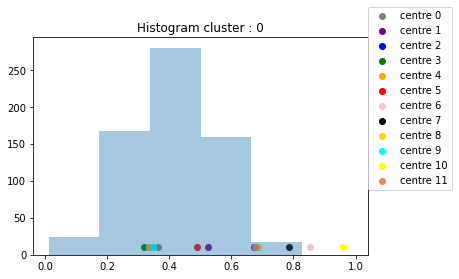

Effectif total de la classe 1 : 788
Nombre de jours dans chaque classe :  [ 95 271 290 115  16   1]


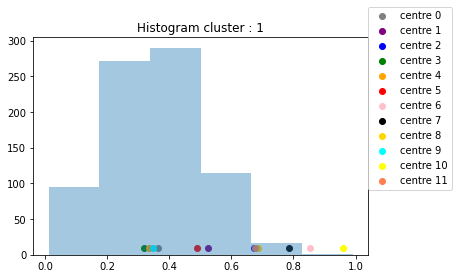

Effectif total de la classe 2 : 429
Nombre de jours dans chaque classe :  [ 57 102  80  71  97  22]


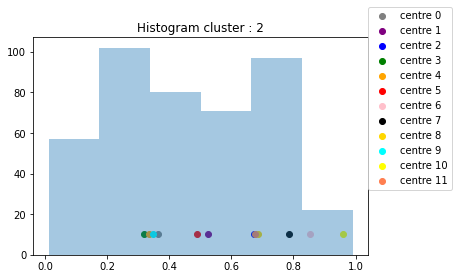

Effectif total de la classe 3 : 328
Nombre de jours dans chaque classe :  [38 71 49 44 58 68]


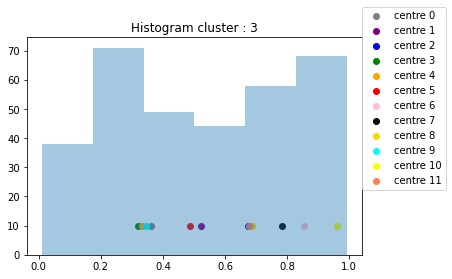

Effectif total de la classe 4 : 568
Nombre de jours dans chaque classe :  [  3  47 160 228 128   2]


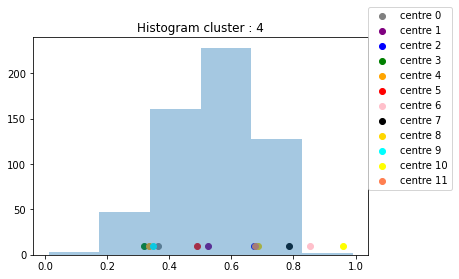

Effectif total de la classe 5 : 526
Nombre de jours dans chaque classe :  [  0  25  99 191 188  23]


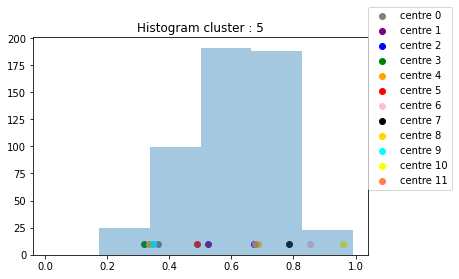

Effectif total de la classe 6 : 423
Nombre de jours dans chaque classe :  [  4  41  86  78  85 129]


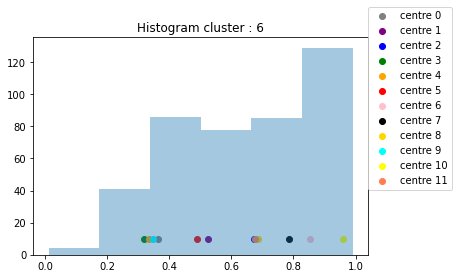

Effectif total de la classe 7 : 601
Nombre de jours dans chaque classe :  [  0   3  19  84 254 241]


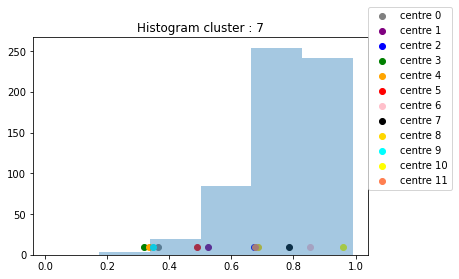

Effectif total de la classe 8 : 440
Nombre de jours dans chaque classe :  [  0   1  25 161 207  46]


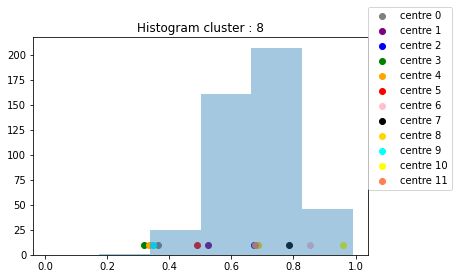

Effectif total de la classe 9 : 703
Nombre de jours dans chaque classe :  [208 346 133  16   0   0]


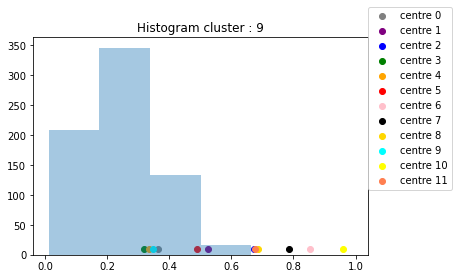

Effectif total de la classe 10 : 630
Nombre de jours dans chaque classe :  [  0   1   7  21 118 483]


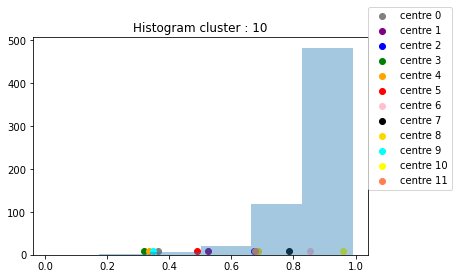

Effectif total de la classe 11 : 487
Nombre de jours dans chaque classe :  [  2  65 203 169  47   1]


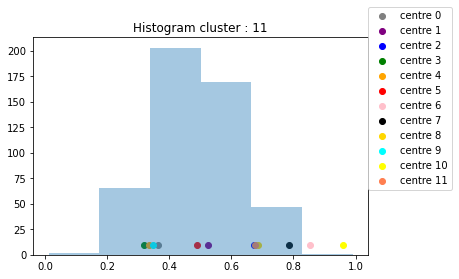

In [18]:
n_clusters = 12
n_groups = 6

centers_off, labels_off = Clustering_days(array_off, n_clusters, verbose_plot = False)

labels_h23_off, groups_h23_off = Labels_h23(h23_off, n_groups)
print("Groupes offshore ", groups_h23_off)

index_centers_off = Index_centers(n_clusters, centers_off, labels_off, array_off)

tab_off = tab_clusters_hours(h23_off, labels_off, n_clusters)
for c in range(n_clusters):
    hist_clusters_hours(tab_off[:,c], c, h23_off, index_centers_off, n_clusters, n_groups)

OFFSHORE
Groupes offshore  [0.01114286 0.20722857 0.40331429 0.5994     0.79548571 0.99157143]
Groupe  7  avec h23 dans le groupe  0  Aucun
Groupe  8  avec h23 dans le groupe  0  Aucun
Groupe  10  avec h23 dans le groupe  0  Aucun


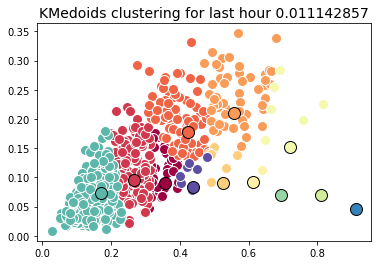

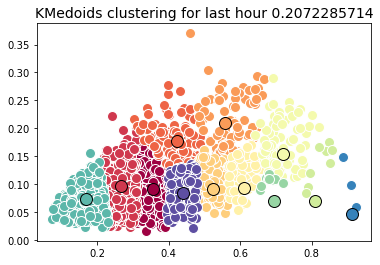

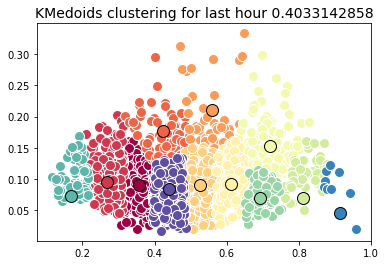

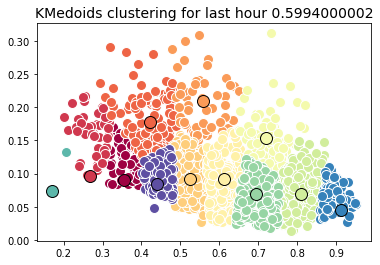

Groupe  0  avec h23 dans le groupe  4  Aucun
Groupe  9  avec h23 dans le groupe  4  Aucun


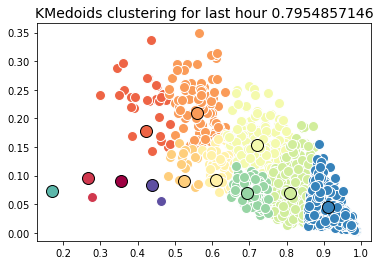

In [19]:
n_clusters = 12
n_groups = 6

print("OFFSHORE")
labels_h23_off, groups_h23_off = Labels_h23(h23_off, n_groups)
print("Groupes offshore ", groups_h23_off)
centers_off, labels_off = Clustering_days(array_off, n_clusters, verbose_plot = False)
Clusters_23h(array_off, centers_off, labels_off, labels_h23_off, groups_h23_off, n_clusters, n_groups)

# print("ONSHORE")
# labels_h23_on, groups_h23_on = Labels_h23(h23_on, n_groups)
# print("Groupes onshore ", groups_h23_on)
# centers_on, labels_on = Clustering_days(array_on, n_clusters, verbose_plot = 0)
# Clusters_23h(array_on, centers_on, labels_on, labels_h23_on, groups_h23_off, n_clusters, n_groups)